# EFI Example: Linear Regression with known σ

## Define EFI Neural Network

In general cases, we consider the data-generating process:

$$
y_i = f(x_i; \theta) + \sigma z_i, \quad \text{where} \quad z_i \sim \pi(z), \quad i = 1, \dots, n
$$

Note that $\pi$ is specified by the statistical model we are interested in. EFI introduces the neural network $G: \mathcal{Y} \times \mathcal{X} \times \mathcal{Z} \to \Theta$ to estimate $\theta$.


In [1]:
import torch
import torch.nn as nn

import numpy as np

import arviz as az

from scipy.stats import t
from scipy.stats import chi2

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches

import seaborn as sns

import scipy
from scipy import stats

import random


## NN structures

def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.2)
            #m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.2)
            #m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m,nn.BatchNorm2d):  # BatchNorm weight init
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)



class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()

        # Define layers
        self.fc1 = nn.Linear(1, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(input_dim, hidden_dim)
        self.fc3 = nn.Linear(1, hidden_dim)
        self.fc4 = nn.Linear(3 * hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, output_dim)

    def forward(self, y, x, z):
        # Pass inputs through the first layer and apply ReLU
        y_out = self.relu(self.fc1(y))
        x_out = self.relu(self.fc2(x))
        z_out = self.relu(self.fc3(z))

        # Concatenate the outputs and pass through the next layers
        concatenated = torch.cat((y_out, x_out, z_out), dim=1)
        hidden_out = self.relu(self.fc4(concatenated))
        output = self.fc5(hidden_out)

        return output

## Training EFI networks

The challenge of statistical inference is that we do not know the true values of the random errors $\{z_i\}_{i=1}^n$ and $\theta$. EFI imputes (samples) the plausible random errors $\hat{z}_i$ using Stochastic Gradient Markov Chain Monte Carlo and estimates $\hat{G}$, which can regenerate or resemble the observed data. Simply speaking, EFI creates reproduced data:

$$
\hat{y}_i = f(x_i; \hat{\theta}) + \hat{z}_i, \quad \text{where} \quad \hat{z}_i \sim p_n^*, \quad i = 1, \dots, n
$$

which satisfies $\sum_{i=1}^n (y_i-\hat{y}_i)^2$ to be small.

EFI then collects the $\hat{\theta}$ values to make the inference. The values of $\hat{\theta}$ vary because the values of $\hat{z}_i$ vary.

$\textbf{Remark:}$  $p_n^*$ is the extended fiducial density function, as defined in the paper. Roughly speaking, $p_n^*$ has the same distributional properties as $\prod_{i=1}^n \pi(z_i)$, but its support only includes plausible values that can reproduce the observed dataset.


0 E[y-\hat(y)]^2: 2.6001837253570557 // theta estimate: [ 0.23  0.23  0.22  0.18  0.25 -0.04 -0.    0.   -0.02 -0.04] // E[Z^2]: 0.8985452651977539
10000 E[y-\hat(y)]^2: 0.05050814896821976 // theta estimate: [ 0.99  0.93  1.01  1.    0.96 -0.11  0.06  0.01  0.02  0.08] // E[Z^2]: 1.048587679862976
20000 E[y-\hat(y)]^2: 0.05330350250005722 // theta estimate: [ 0.91  0.92  0.98  0.9   0.98  0.05  0.08 -0.05 -0.05 -0.02] // E[Z^2]: 1.086856484413147
30000 E[y-\hat(y)]^2: 0.04652008041739464 // theta estimate: [ 1.04  1.07  0.93  0.95  1.02 -0.14 -0.04  0.04  0.03  0.01] // E[Z^2]: 1.0330986976623535
40000 E[y-\hat(y)]^2: 0.04653779789805412 // theta estimate: [ 1.01  0.96  0.97  0.9   1.04  0.03  0.07 -0.01  0.04 -0.04] // E[Z^2]: 1.070367455482483
50000 E[y-\hat(y)]^2: 0.05129341036081314 // theta estimate: [ 0.95  0.99  1.03  1.01  1.09 -0.02 -0.06 -0.   -0.01 -0.1 ] // E[Z^2]: 1.0526225566864014
60000 E[y-\hat(y)]^2: 0.04970943555235863 // theta estimate: [ 1.12  1.04  1.    1.    1.0

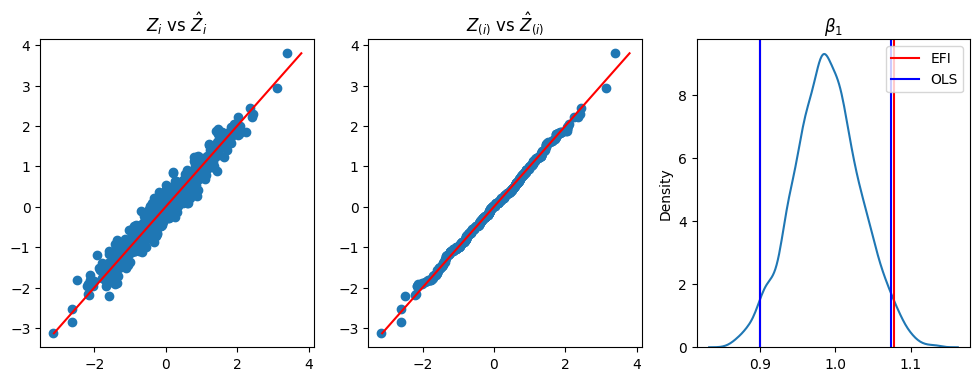

In [2]:
## Set seed

np.random.seed(500)
torch.manual_seed(500)

## True DGP settings
true_theta=torch.tensor([1,1,1,1,1,0,0,0,0,0])
p=10

true_sigma2=1 ; true_sigma=np.sqrt(true_sigma2)

N=500
batch_size=N

## Replicates

S=1 ## S=100
X_dataset=torch.randn((S,N,p-1))
Z_dataset=torch.randn((S,N))



## Sparse DNN settings

l=1e-2
sigma_0=np.sqrt(1e-5)
sigma_1=np.sqrt(0.02)

c1=np.log(l)-np.log(1-l)+1/2*np.log(sigma_0**2)-1/2*np.log(sigma_1**2)
c2=1/2/sigma_0**2-1/2/sigma_1**2

threshold=np.sqrt(np.log( (1-l)/l *sigma_1/sigma_0 )/(1/(2*sigma_0**2)-1/(2*sigma_1**2)))

## EFI settings

lambda_1=100
lambda_2=10

K=1000
M=100000

mseloss=nn.MSELoss()


for s in range(S):

  ## Prepare dataset

  X=torch.cat((torch.ones(N,1),X_dataset[s]),1)
  true_Z=Z_dataset[s]
  y=torch.sum(true_theta*X,1)+true_sigma*true_Z
  y=y.view(N,1).cuda()
  X=X.cuda()

  ## Initialize the imputed Z (latent variable), we use the SGLD

  Z=(torch.randn(N,1)).cuda().requires_grad_()
  momentum=torch.zeros(Z.size()).cuda()
  alpha=1


  ## OLS(GFD,MLE) solutions

  XTX=torch.matmul(X.T,X).cuda()
  XTX_inv=torch.inverse(torch.matmul(X.T,X)).cuda()
  P_X=torch.matmul(torch.matmul(X,XTX_inv),X.T).cuda()
  hat_beta=torch.matmul(torch.matmul(XTX_inv,X.T),y).cuda()
  # hat_sigma=torch.sqrt((torch.sum(y**2)-torch.sum(y*torch.matmul(P_X,y)))/(N-p))

  ## EFI results

  ci_bar_region=[]
  ci_sigma_region=[]
  ci_Z=[]

  lr_d=0.01/N
  lr_g=0.05/N

  Encoder=FeedforwardNeuralNetModel(p,100,10).cuda()
  Encoder.apply(initialize_weights)
  E_optimizer=torch.optim.SGD(Encoder.parameters(),lr=lr_d )

  for iter in range(K+int(N/batch_size)*M):

      lr_g=50000/(10000+(iter+1)**(13/14))/N
      lr_d=5000/(100000+(iter+1)**(4/7))/N

      for param_group in E_optimizer.param_groups:
        param_group['lr'] = lr_d

      ##### 1. Latent variable sampling (Sample Z)

      thetas=Encoder(y,X,Z)

      bar_theta =torch.mean(thetas,0)

      tilde_y=torch.sum(bar_theta[:p]*X,1).view(batch_size,1)+Z


      Z_loss=  N*lambda_2*mseloss(y,tilde_y)+lambda_1*N*mseloss(thetas,bar_theta.repeat(N,1))+N*torch.mean(Z**2)/2

      if Z.grad is not None:
        Z.grad.zero_()
      Z_loss.backward()

      momentum.data *=(1-alpha)
      momentum.data += -lr_g * Z.grad + torch.FloatTensor(Z.shape).cuda().normal_().mul(np.sqrt(2*alpha*lr_g))

      Z.data += momentum

      with torch.no_grad():
          Z.clamp_(-100, 100)


      #### 2. DNN weights update (Optimize W)


      thetas=Encoder(y,X,Z)

      bar_theta =torch.mean(thetas,0)

      tilde_y=torch.sum(bar_theta[:p]*X,1).view(batch_size,1)+Z

      consistent_loss=N*lambda_2*mseloss(y,tilde_y)+lambda_1*N*mseloss(thetas,bar_theta.repeat(N,1))

      E_loss=consistent_loss
      E_optimizer.zero_grad()
      E_loss.backward()

      with torch.no_grad():
        for param in Encoder.parameters():
          temp=1/(torch.exp(c2*torch.mul(param.data,param.data)+c1)+1)
          prior=-torch.mul(param.data,temp)/sigma_0**2-torch.mul(param.data,(1-temp))/sigma_1**2
          param.grad.data -=prior/N
          #print(prior)

      if iter<2000:
        torch.nn.utils.clip_grad_norm_(Encoder.parameters(),5000)

      E_optimizer.step()

      ## Result check

      if (iter%10000==0):

        thetas=Encoder(y,X,Z)

        bar_theta =torch.mean(thetas,0)

        tilde_y=torch.sum(bar_theta[:p]*X,1).view(batch_size,1)+Z

        similarity = mseloss(y,tilde_y)

        print(
            f"{iter} E[y-\hat(y)]^2: {similarity.item()} // "
            f"theta estimate: {bar_theta.detach().cpu().numpy().round(2)} // "
            f"E[Z^2]: {torch.mean(Z**2).item()}"
        )
      ## MC samples

      if (iter>K) and (iter%10==0) :

        thetas=Encoder(y,X,Z)

        bar_theta =torch.mean(thetas,0)

        ci_bar_region.append(bar_theta.detach().cpu().numpy())
        ci_Z.append(((Z).view(N).detach().cpu().numpy()))


  ci_bar_region=np.vstack(ci_bar_region)
  hdi_bar=np.quantile(ci_bar_region,[0.025,0.975],axis=0).T

  ci=[]
  q=[]

  for i in range(10):
      q=(1.96*torch.sqrt(XTX_inv[i,i])).detach().cpu().numpy()
      ci.append([hat_beta.detach().cpu().numpy()[i]-q,hat_beta.detach().cpu().numpy()[i]+q])

  check=1  ### index of beta cofficients

  fig, axes = plt.subplots(1, 3,figsize=(12,4))
  for i in range(2):
    if i==0:
      true_Z_np=(true_sigma*true_Z).detach().cpu().numpy()
      Z_np=Z.detach().cpu().numpy()

      plot_x = np.linspace(min(Z_np),max(Z_np),100)
      plot_y = plot_x
      axes[i].plot(plot_x,plot_y,"r")
      axes[i].scatter(true_Z_np,Z_np.reshape(N))

    if i==1:
      plot_x = np.linspace(min(Z_np),max(Z_np),100)
      plot_y = plot_x
      axes[i].plot(plot_x,plot_y,"r")
      axes[i].scatter(np.sort(true_Z_np),(np.sort(Z_np.reshape(N))))

  axes[0].set_title(r"$Z_{i}$" +" vs "+ r"$\hat{Z}_{i}$"  )
  axes[1].set_title(r"$Z_{(i)}$" +" vs "+ r"$\hat{Z}_{(i)}$")
  axes[2].set_title(r"$\beta_1$")
  sns.kdeplot(ci_bar_region[:,check],ax=axes[2])
  axes[2].axvline(x=hdi_bar[check][0], ymin=0, ymax=1,color="r",label="EFI")
  axes[2].axvline(x=hdi_bar[check][1], ymin=0, ymax=1,color="r")
  axes[2].axvline(x=ci[check][0], ymin=0, ymax=1,color="b",label="OLS")
  axes[2].axvline(x=ci[check][1], ymin=0, ymax=1,color="b")
  axes[2].legend(loc="upper right")
  plt.show()





